In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

%load_ext autoreload
%autoreload 2
from trader.utils import *
from trader.tradertk import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
# get_x??

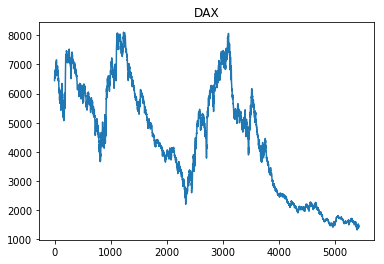

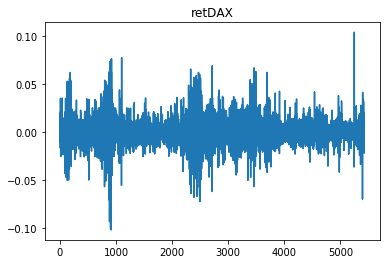

std(retDAX):  0.0147580478684


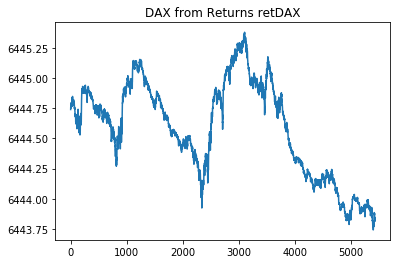

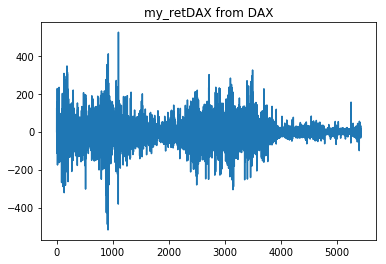

In [112]:
with open('data/retDAX.txt', 'r') as f:
    tmp = f.read()
    
retDAX = list(map(lambda x: float(x), tmp.split()))

with open('data/DAX.txt', 'r') as f:
    tmp = f.read()
    
DAX = list(map(lambda x: float(x), tmp.split()))

plt.plot(DAX)
plt.title('DAX')
plt.show()
plt.plot(retDAX)
plt.title('retDAX')
plt.show()

print('std(retDAX): ', np.std(retDAX))

tmp = [DAX[0]]
for x in retDAX:
    tmp.append(tmp[-1] + x)

plt.plot(tmp)
plt.title('DAX from Returns retDAX')
plt.show()

my_retDAX = [0]
for i in range(1, len(DAX)):
    my_retDAX.append(DAX[i] - DAX[i-1])
    
plt.plot(my_retDAX)
plt.title('my_retDAX from DAX')
plt.show()

# Here goes the main part:

# Experimenting....

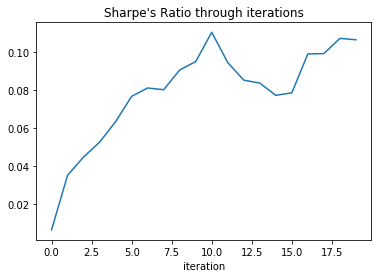

In [145]:
M = 10  # The number of time series inputs to the trader.
w = np.random.uniform(0.0, 1.0, M+3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0001  # Cost for a transaction at period t.

maxT = 500
num_iter = 20
learning_rate = 0.01

sums_rew = []
last_srs = []

for iterr in range(num_iter):
    X = build_x(maxT, M, my_retDAX, w)
    
    ##################
    # Get values of Trader Function.
    ##################
    F = np.array(X)[:,M+2]  # Last coordinates of X vectors.
    
    ##################
    # Calculate rewards till time step maxT.
    ##################
    rewards, s_ratio = get_rewards(maxT, my_retDAX, F, miu, delta)
    
    ##################
    # Calculate gradient dFt/dw.
    ##################
    dFt = [(1 - (traderFunction(X[0], w) ** 2)) * X[0]]
    for t in range(maxT):
        dFt.append((1 - (traderFunction(X[0], w) ** 2)) * (X[t] + (w[-1] * dFt[-1])))
        
    ##################
    # Gradient Calculations.
    ##################
    someT = maxT

    A = sum(rewards[:someT]) / someT
    B = sum(np.array(rewards[:someT]) ** 2) / someT

    dSdA = (1 / np.sqrt(B - (A ** 2))) + ((A ** 2) / ((B - (A ** 2)) ** (3/2)))
    dSdB = -1 * (A / (2 * (((B - (A ** 2))) ** (3/2))))

    grad = 0
    for t in range(1, someT):
        dAdR = 1 / someT
        dBdR = 2 * rewards[t] / someT

        dRdFt = -1 * miu * delta * np.sign(F[t] - F[t-1])
        dRdFtt = (miu * my_retDAX[t]) - dRdFt

        dFtdw = dFt[t]
        dFttdw = dFt[t-1]

        grad += (dSdA*dAdR + dSdB*dBdR) * (dRdFt*dFtdw + dRdFtt*dFttdw)

    ##################
    # Weights update.
    ##################
    w_old = w.copy()
    w += learning_rate * grad
    
    sums_rew.append(sum(rewards)) 
    last_srs.append(s_ratio)

plt.plot(last_srs)
plt.title("Sharpe's Ratio through iterations")
plt.xlabel('iteration')
plt.show()